In [1]:
!pip install pillow webcolors requests beautifulsoup4 WordCloud

In [1]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from collections import Counter
from bs4 import BeautifulSoup

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


def extract_product_color(image_url, num_clusters=5, threshold=10.0):
    try:
        # Load the image
        response = requests.get(image_url)
        if response.status_code==404:
          return ("","Unknown")
        response.raise_for_status()
        img_data = BytesIO(response.content)
        img = Image.open(img_data)
        img = img.convert('RGB')

        image_array = np.array(img)

        # Convert to BGR format (required for OpenCV)
        image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

        # Apply GrabCut segmentation to identify the item
        mask = np.zeros(image_bgr.shape[:2], np.uint8)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        rect = (10, 10, image_bgr.shape[1] - 10, image_bgr.shape[0] - 10)
        cv2.grabCut(image_bgr, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

        # Create a mask to extract the item (1 for likely foreground, 3 for definite foreground)
        mask2 = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')

        # Apply the mask to the image
        segmented_item = cv2.bitwise_and(image_bgr, image_bgr, mask=mask2)

        # Convert segmented item to RGB format
        segmented_item_rgb = cv2.cvtColor(segmented_item, cv2.COLOR_BGR2RGB)

        # Reshape the segmented item to be a list of pixels
        pixels = segmented_item_rgb.reshape((-1, 3))

        # Perform KMeans clustering on the pixels
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(pixels)

        # Count the number of pixels in each cluster
        cluster_pixel_counts = Counter(kmeans.labels_)

        # Find the cluster with the largest number of pixels
        dominant_cluster_index = max(cluster_pixel_counts, key=lambda k: cluster_pixel_counts[k])
        dominant_color = kmeans.cluster_centers_[dominant_cluster_index]

        # Convert the dominant color to RGB format
        rgb_dominant_color = tuple(int(channel) for channel in dominant_color)

        # Convert RGB to hex format
        hex_color = "#{:02x}{:02x}{:02x}".format(*rgb_dominant_color)

        # Attempt to find a recognized color name
        url = f"https://www.color-name.com/hex/{hex_color.lstrip('#')}"

        # Send an HTTP GET request
        response = requests.get(url)
        response.raise_for_status()

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the color name in the page content
        color_name = soup.find('h4', class_='color-code').text.strip().split("Name: ")[1]

        return (hex_color,color_name)
    except Exception as e:
        print("Error:", str(e))
        return "Unknown"

In [2]:
import pandas as pd
product_data_df=pd.read_csv("https://query.data.world/s/ftetk3amqs7xvggy5lljxnm6cajzxk?dws=00000",low_memory=False,on_bad_lines='skip')

In [3]:
product_data_df.head()

,Uniq Id,Crawl Timestamp,Bb Category,Product Title,Product Description,Brand,Quantity Or Pack Size,Mrp,Price,Site Name,Offers,Combo Offers,Stock Availibility,Image Url,Url
0,0633d9fd9a3271730fae687f105c7a3a,2019-11-12 00:46:19 0000,Juices,B Natural Dakshin Pink Guava (750 ml),NaN,B Natural,750 ml Plastic Bottle,99,95,flipkart_com,Bank Offer 5% Unlimited Cashback on Flipkart A...,NaN,True,https://rukminim1.flixcart.com/image/832/832/j...,https://www.flipkart.com/b-natural-dakshin-pin...
1,8687c5317c6629f89fe62e0233563246,2019-11-28 00:31:50 0000,Chocolates & Sweets,Parle Melody Chocolaty Toffee (195.5 g),NaN,Parle,195.5 g,50,50,flipkart_com,Bank Offer 10% Cashback* on HDFC Bank Debit Ca...,NaN,True,https://rukminim1.flixcart.com/image/832/832/j...,https://www.flipkart.com/parle-melody-chocolat...
2,cf7eeba428641c14e43aa18ada1b5491,2019-11-04 00:48:32 0000,Household Care|Pet Food,Whiskas Adult (+1 year) Fish 3 kg Dry Cat Food,These little pockets of fish cat food are goin...,Whiskas,3 kg,800,680,flipkart_com,Bank Offer 5% Unlimited Cashback on Flipkart A...,NaN,True,https://rukminim1.flixcart.com/image/832/832/j...,https://www.flipkart.com/whiskas-adult-1-year-...
3,9eb4d8359a3cbe7af6c5ac1c3149940e,2019-11-26 00:33:04 0000,"Creams, Lotions, Skin Care",Enchanteur Romantic Perfumed Body Lotion (250...,NaN,Enchanteur,250 ml,220,182,flipkart_com,Bank Offer 10% Cashback* on HDFC Bank Debit Ca...,NaN,True,https://rukminim1.flixcart.com/image/832/832/k...,https://www.flipkart.com/enchanteur-romantic-p...
4,b84c9f6fc53da0c6921147063d894703,2019-11-24 00:32:29 0000,Hair Care,Pantene Hair Fall Control Shampoo (180 ml),If your hair falls frequently and you leave be...,Pantene,180 ml,115,112,flipkart_com,Bank Offer 10% Instant Discount on Federal Ban...,NaN,True,https://rukminim1.flixcart.com/image/832/832/j...,https://www.flipkart.com/pantene-hair-fall-con...


In [4]:
product_data_df.shape

(14935, 15)

In [5]:
product_data_df=product_data_df.head(400)

In [6]:
product_data_df.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Bb Category', 'Product Title',
       'Product Description', 'Brand', 'Quantity Or Pack Size', 'Mrp', 'Price',
       'Site Name', 'Offers', 'Combo Offers', 'Stock Availibility',
       'Image Url', 'Url'],
      dtype='object')

In [7]:
product_data_df.rename(columns={"Uniq Id": "product_id"}, inplace=True)
product_data_df.rename(columns={"Bb Category": "category"}, inplace=True)
product_data_df.rename(columns={"Product Title": "product_name"}, inplace=True)
product_data_df.rename(columns={"Image Url": "image"}, inplace=True)
product_data_df.rename(columns={"Price": "price"}, inplace=True)

In [8]:
product_data_df=product_data_df[["product_id","category","product_name","price","image"]]

In [9]:
for col in product_data_df.columns:
  print(f'{col} null count: {product_data_df[col].isna().sum()}')

product_id null count: 0
category null count: 0
product_name null count: 0
price null count: 0
image null count: 0


In [10]:
product_data_df["image"].values[0]

'https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmm2yj3nrgw.jpeg?q=70|https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmhgqyqktzk.jpeg?q=70|https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmmgyzfhgvm.jpeg?q=70|https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmmtrqagvjs.jpeg?q=70|https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmmpgcqmhkb.jpeg?q=70'

In [11]:
product_data_df["image"] = np.array([x.split("|http")[0] for x in product_data_df["image"]])

In [12]:
product_data_df["image"].values[0]

'https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmm2yj3nrgw.jpeg?q=70'

In [13]:
ls1,ls2=[],[]
for i,x in enumerate(product_data_df["image"]):
    hex_color,name=extract_product_color(x)
    ls1.append(hex_color)
    ls2.append(name)
    print(i+1, end=" ")
product_data_df["color_hex"]=np.array(ls1)
product_data_df["color"]=np.array(ls2)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [14]:
product_data_df.head()

,product_id,category,product_name,price,image,color_hex,color
0,0633d9fd9a3271730fae687f105c7a3a,Juices,B Natural Dakshin Pink Guava (750 ml),95,https://rukminim1.flixcart.com/image/832/832/j...,#b37972,Rose Gold
1,8687c5317c6629f89fe62e0233563246,Chocolates & Sweets,Parle Melody Chocolaty Toffee (195.5 g),50,https://rukminim1.flixcart.com/image/832/832/j...,#0a090b,Vampire Black
2,cf7eeba428641c14e43aa18ada1b5491,Household Care|Pet Food,Whiskas Adult (+1 year) Fish 3 kg Dry Cat Food,680,https://rukminim1.flixcart.com/image/832/832/j...,#9c288b,Violet (Crayola)
3,9eb4d8359a3cbe7af6c5ac1c3149940e,"Creams, Lotions, Skin Care",Enchanteur Romantic Perfumed Body Lotion (250...,182,https://rukminim1.flixcart.com/image/832/832/k...,#f1eef2,Anti-Flash White
4,b84c9f6fc53da0c6921147063d894703,Hair Care,Pantene Hair Fall Control Shampoo (180 ml),112,https://rukminim1.flixcart.com/image/832/832/j...,#000000,Black


In [15]:
print(product_data_df.index[product_data_df['color'] == 'Unknown'])

Int64Index([62], dtype='int64')


In [16]:
try:
    indices = product_data_df.index[product_data_df['color'] == 'Unknown']
    print(indices)
    product_data_df=product_data_df.drop(indices)
    print("Dropped indices where image link was not correct")
except ValueError:
    print("Value not found in 'Column1'")

Int64Index([62], dtype='int64')
Dropped indices where image link was not correct


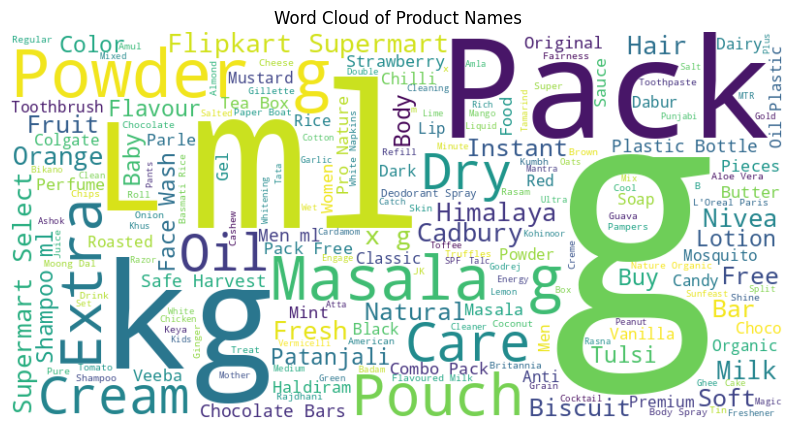

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate product names
all_product_names = ' '.join(product_data_df['product_name'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_product_names)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Product Names')
plt.axis('off')
plt.show()

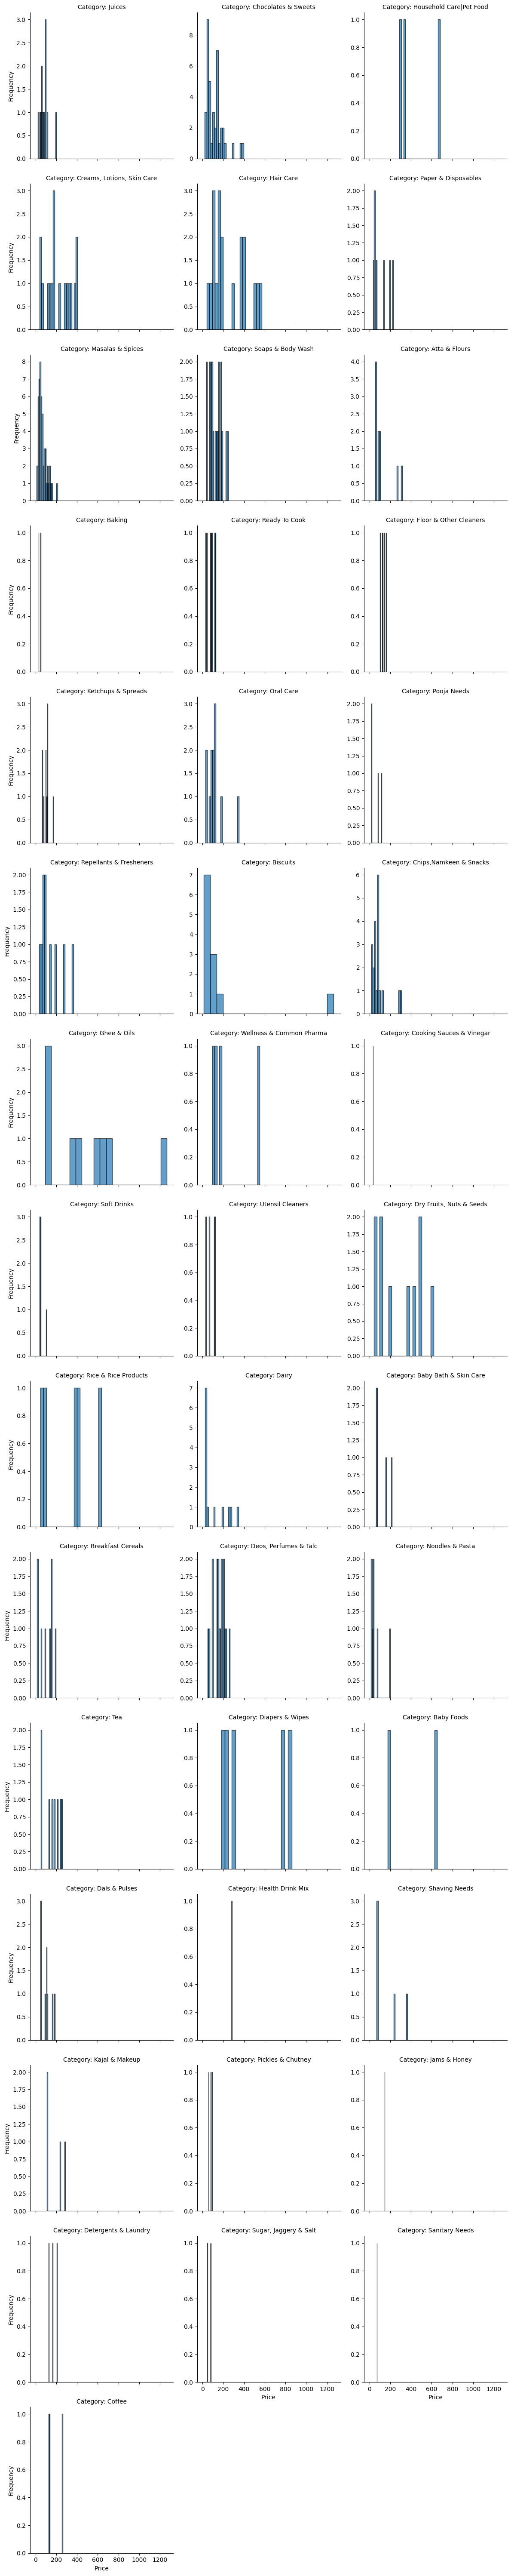

In [9]:
import seaborn as sns

# Create a facet grid of histograms for each category
g = sns.FacetGrid(product_data_df, col='category', col_wrap=3, height=4, sharey=False)
g.map(plt.hist, 'price', bins=20, edgecolor='black', alpha=0.7)
g.set_titles('Category: {col_name}')
g.set_xlabels('Price')
g.set_ylabels('Frequency')
g.tight_layout()
plt.show()


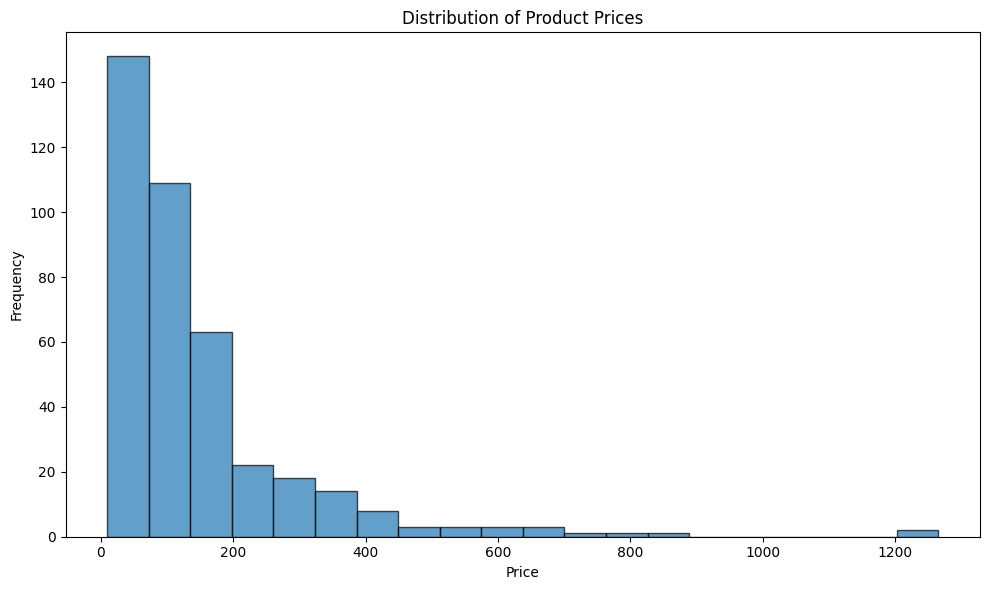

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(product_data_df['price'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

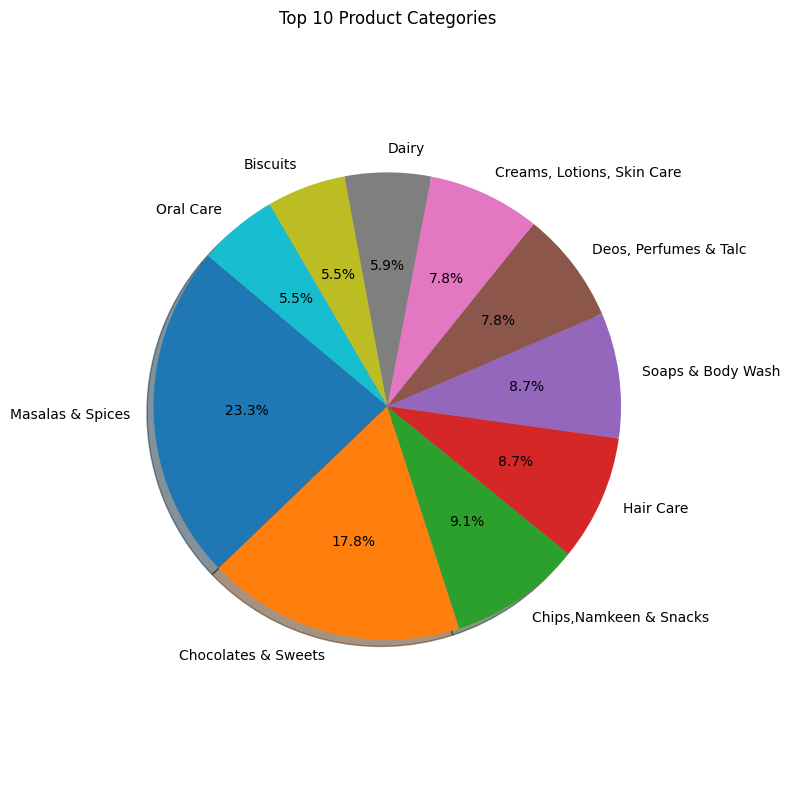

In [11]:
top_categories = product_data_df['category'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_categories, labels=top_categories.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Top 10 Product Categories')
plt.axis('equal')
plt.tight_layout()
plt.show()

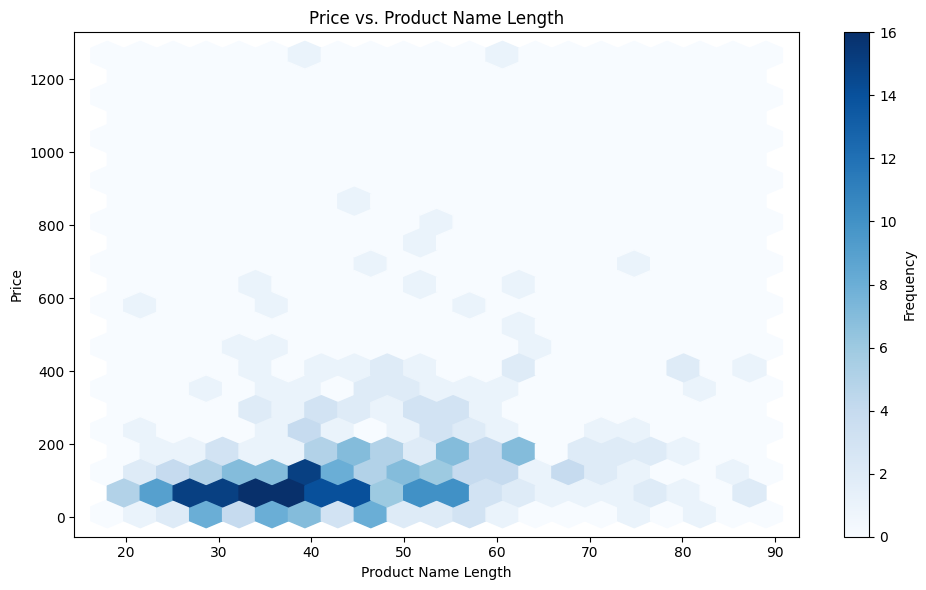

In [12]:
product_data_df['product_name_length'] = product_data_df['product_name'].apply(len)

plt.figure(figsize=(10, 6))
plt.hexbin(product_data_df['product_name_length'], product_data_df['price'], gridsize=20, cmap='Blues')
plt.title('Price vs. Product Name Length')
plt.xlabel('Product Name Length')
plt.ylabel('Price')
plt.colorbar(label='Frequency')
plt.tight_layout()
plt.show()

In [18]:
for i,x in enumerate(product_data_df["price"]):
  try:
    t=float(x)
  except Exception as e:
    print(f"Incompatible value: {x} at index: {i}")
    product_data_df.loc[i,'price']="".join(x.split(","))
    print(f"Changed that value\n")
    continue

product_data_df.to_csv("products.csv", index=False)

Incompatible value: 1,265 at index: 179
Changed that value

